<a href="https://colab.research.google.com/github/nahuelalmeira/graphMachineLearning/blob/main/notebooks/PyTorch_Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración del entorno PyTorch para utilizar el algoritmo node2vec

### Configuración general

In [15]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 325 kB 33.5 MB/s 
     |████████████████████████████████| 407 kB 29.5 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=46551475089dcbc7eed1058a59fbeee73e0593a6296c2506065c1b59a5b3c867
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


In [16]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [61]:
import numpy as np
import networkx as nx

from torch_geometric.nn import Node2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

In [64]:
g = nx.karate_club_graph()
print(nx.info(g))

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


In [65]:
n = g.number_of_nodes()
nodes = [v for v in g.nodes()]
membership = np.array([g.nodes[v]['club'] for v in g])

## Matrices esparsas

Para hacer uso eficiente de la memoria, PyTorch-Geometric utiliza matrices esparsas. En particular usa el formato de coordenadas, o [COO](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)).

In [19]:
adj = nx.to_scipy_sparse_matrix(g).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

## Node2Vec

In [93]:
## Definimos nuestro modelo
model = Node2Vec(
    edge_index, embedding_dim=100, walk_length=10, 
    context_size=4, num_negative_samples=5
).to(device)

## El loader es un wrapper que nos permite trabajar por lotes, 
## para utilizar descenso por el gradiente estocástico y
## sus variantes
loader = model.loader(batch_size=128, shuffle=True)

## Optimizador
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

Definimos la función de entrenamiento

In [94]:
def train():
    ## Ponemos nuestro modelo en modo entrenamiento
    model.train()

    total_loss = 0
    for pos_rw, neg_rw in loader:

        ## Reseteamos los gradientes
        optimizer.zero_grad()

        ## Calculamos el error (la función de costo) del lote
        ## en función de los samples positivos y negativos
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))

        ## Hacemos backpropagation
        loss.backward()

        ## Avanzamos un paso
        optimizer.step()

        ## Actualizamos la función de costo total
        total_loss += loss.item()

    return total_loss / len(loader)

Entrenamos el modelo

In [95]:
epochs = 100
for epoch in range(epochs):
    loss = train()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3} - Loss: {loss:.3f}')

Epoch:   0 - Loss: 8.346
Epoch:   5 - Loss: 7.028
Epoch:  10 - Loss: 6.344
Epoch:  15 - Loss: 5.152
Epoch:  20 - Loss: 4.341
Epoch:  25 - Loss: 3.955
Epoch:  30 - Loss: 3.762
Epoch:  35 - Loss: 3.644
Epoch:  40 - Loss: 3.003
Epoch:  45 - Loss: 3.310
Epoch:  50 - Loss: 3.070
Epoch:  55 - Loss: 2.867
Epoch:  60 - Loss: 2.711
Epoch:  65 - Loss: 2.568
Epoch:  70 - Loss: 2.846
Epoch:  75 - Loss: 2.572
Epoch:  80 - Loss: 2.553
Epoch:  85 - Loss: 2.493
Epoch:  90 - Loss: 2.679
Epoch:  95 - Loss: 2.671


Obtenemos el embedding

In [96]:
def get_embedding():
    model.eval()
    with torch.no_grad():
        nodes = torch.arange(g.number_of_nodes(), device=device)
        embedding = model(nodes).detach().numpy()
    return embedding

embedding = get_embedding()

Reducimos la dimensión del embedding para poder graficar

In [97]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

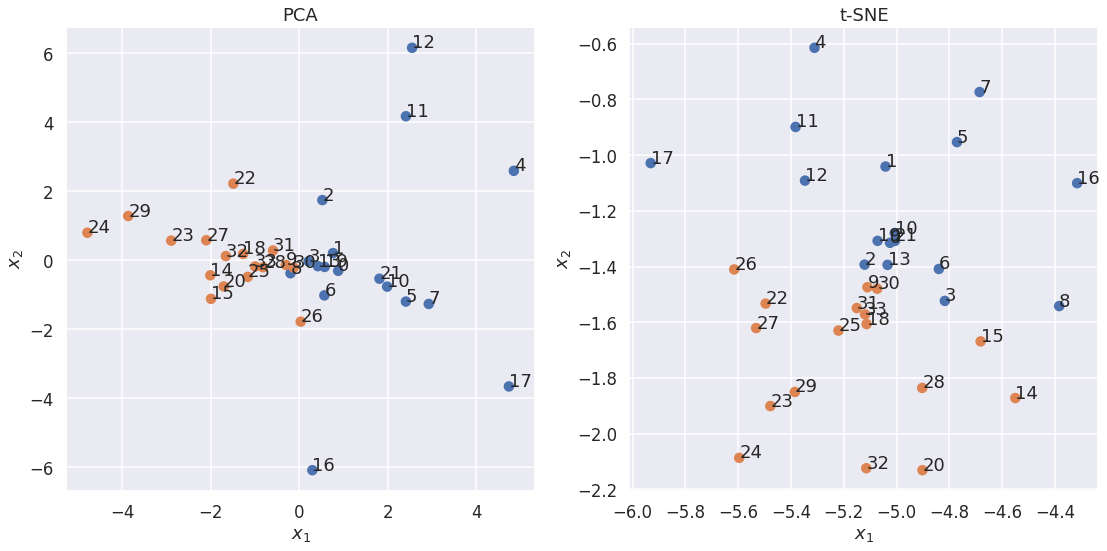

In [98]:
def add_labels(g, pos, ax):
    labels = [v for v in g.nodes()]
    for i in range(g.number_of_nodes()):
        x, y = pos[i]
        label = labels[i]
        ax.text(x, y, label)

color = ['C0' if elem == 'Mr. Hi' else 'C1' for elem in membership]
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
ax.scatter(pca[:,0], pca[:,1], c=color)
add_labels(g, pca, ax)
ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
ax.scatter(tsne[:,0], tsne[:,1], c=color)
add_labels(g, tsne, ax)
plt.tight_layout()
plt.show()